# 1. Import & Setting

### 1-1) Path Setting

In [1]:
import os
project_path = "C:/workspace/Bus Project"
os.chdir(project_path)

### 1-2) Import

In [2]:
import datetime
import numpy as np
import pandas as pd
import multiprocessing
from functools import partial
from multiprocessing import Pool

import bus.analyzer as anz

### 1-3) 한글 폰트 설정

In [3]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

# 2. 이용자 & 정류장 추출

### 2-1) - 이용데이터 로딩

In [4]:
# 데이터 기간 설정
start_date = datetime.datetime(2019, 6, 1)
end_date = datetime.datetime(2019, 8, 29)

# 로딩할 파일 명 리스트 생성
input_path_list = anz.make_input_path(start_date, end_date)

# 전체 데이터 로딩 (multi)
usage_df = anz.parallel_load_total_usage_df(input_path_list)

### 2-2) - 정류장 추출 & 분석

In [6]:
#정류장 추출
station_df = anz.create_station_df(usage_df)
print("추출된 정류장 개수: ",len(station_df))

# # 주소 컬럼 추가
station_df = anz.set_address_column(station_df)

# # sorting
station_df = station_df.sort_values(by="station_id")

# # storing
station_df.to_csv("data/analysis/station_df.csv", encoding="CP949", index=False)

In [7]:
station_df = anz.load_station_df()

### 2-3) - 이용자 추출 & 분석

In [8]:
# 유저 목록 생성
user_df = anz.create_user_df(usage_df)

# 이용 날짜 분석 완료
user_df = anz.analyze_usage_date(user_df, usage_df)

# 이용 횟수 분석 완료
user_df = anz.analyze_usage_num(user_df, usage_df)

# 이용 비율 분석 완료
user_df = anz.parallel_analyze_usage_ratio(user_df)

# 출발, 도작지 분석 완료
user_df = anz.analyze_start_end(user_df, usage_df)

### 2-4) 관광객 추출

In [9]:
# case1, 2의 사용 정류장 추출 및 저장
both_station_df = anz.extract_used_station(user_df, usage_df, station_df, 'both')
both_station_df.to_csv("data/analysis/used_station_df.csv", encoding="cp949", index=False)

# HAND WORK - "data/case1_2.csv"를 보고 직접 관광 관련 정류장 컬럼을 삽입하고 "data/case1_2_filtered.csv"로 저장
tour_station_df = pd.read_csv("data/analysis/tour_station_df.csv", low_memory=False, encoding = "utf-8") #, dtype=dtype)

# 관광관련 정류장 방문 횟수 분석
user_df = anz.analyze_tour_station_visit(user_df, usage_df, tour_station_df)

# 이용자 케이스 분류
user_df = anz.parallel_analyze_case(user_df)

# 관광객 분석
user_df = anz.parallel_analyze_tourist(user_df)

### 2-5) 정류장 이용 분석 

In [9]:
# 정류장 분석
station_df = anz.analyze_station_usage(station_df, usage_df, user_df)

### 2-6) 이용자 및 정류장 저장

In [10]:
# 이용자 데이터 저장
user_df.to_csv("data/analysis/user_df.csv", encoding="cp949", index=False)

# 정류장 데이터 저장
station_df.to_csv("data/analysis/station_df.csv", encoding="CP949", index=False)

# 3. 관광객 추출 알고리즘 검증

### 3-1) 알고리즘 검증 - tour_visit검증

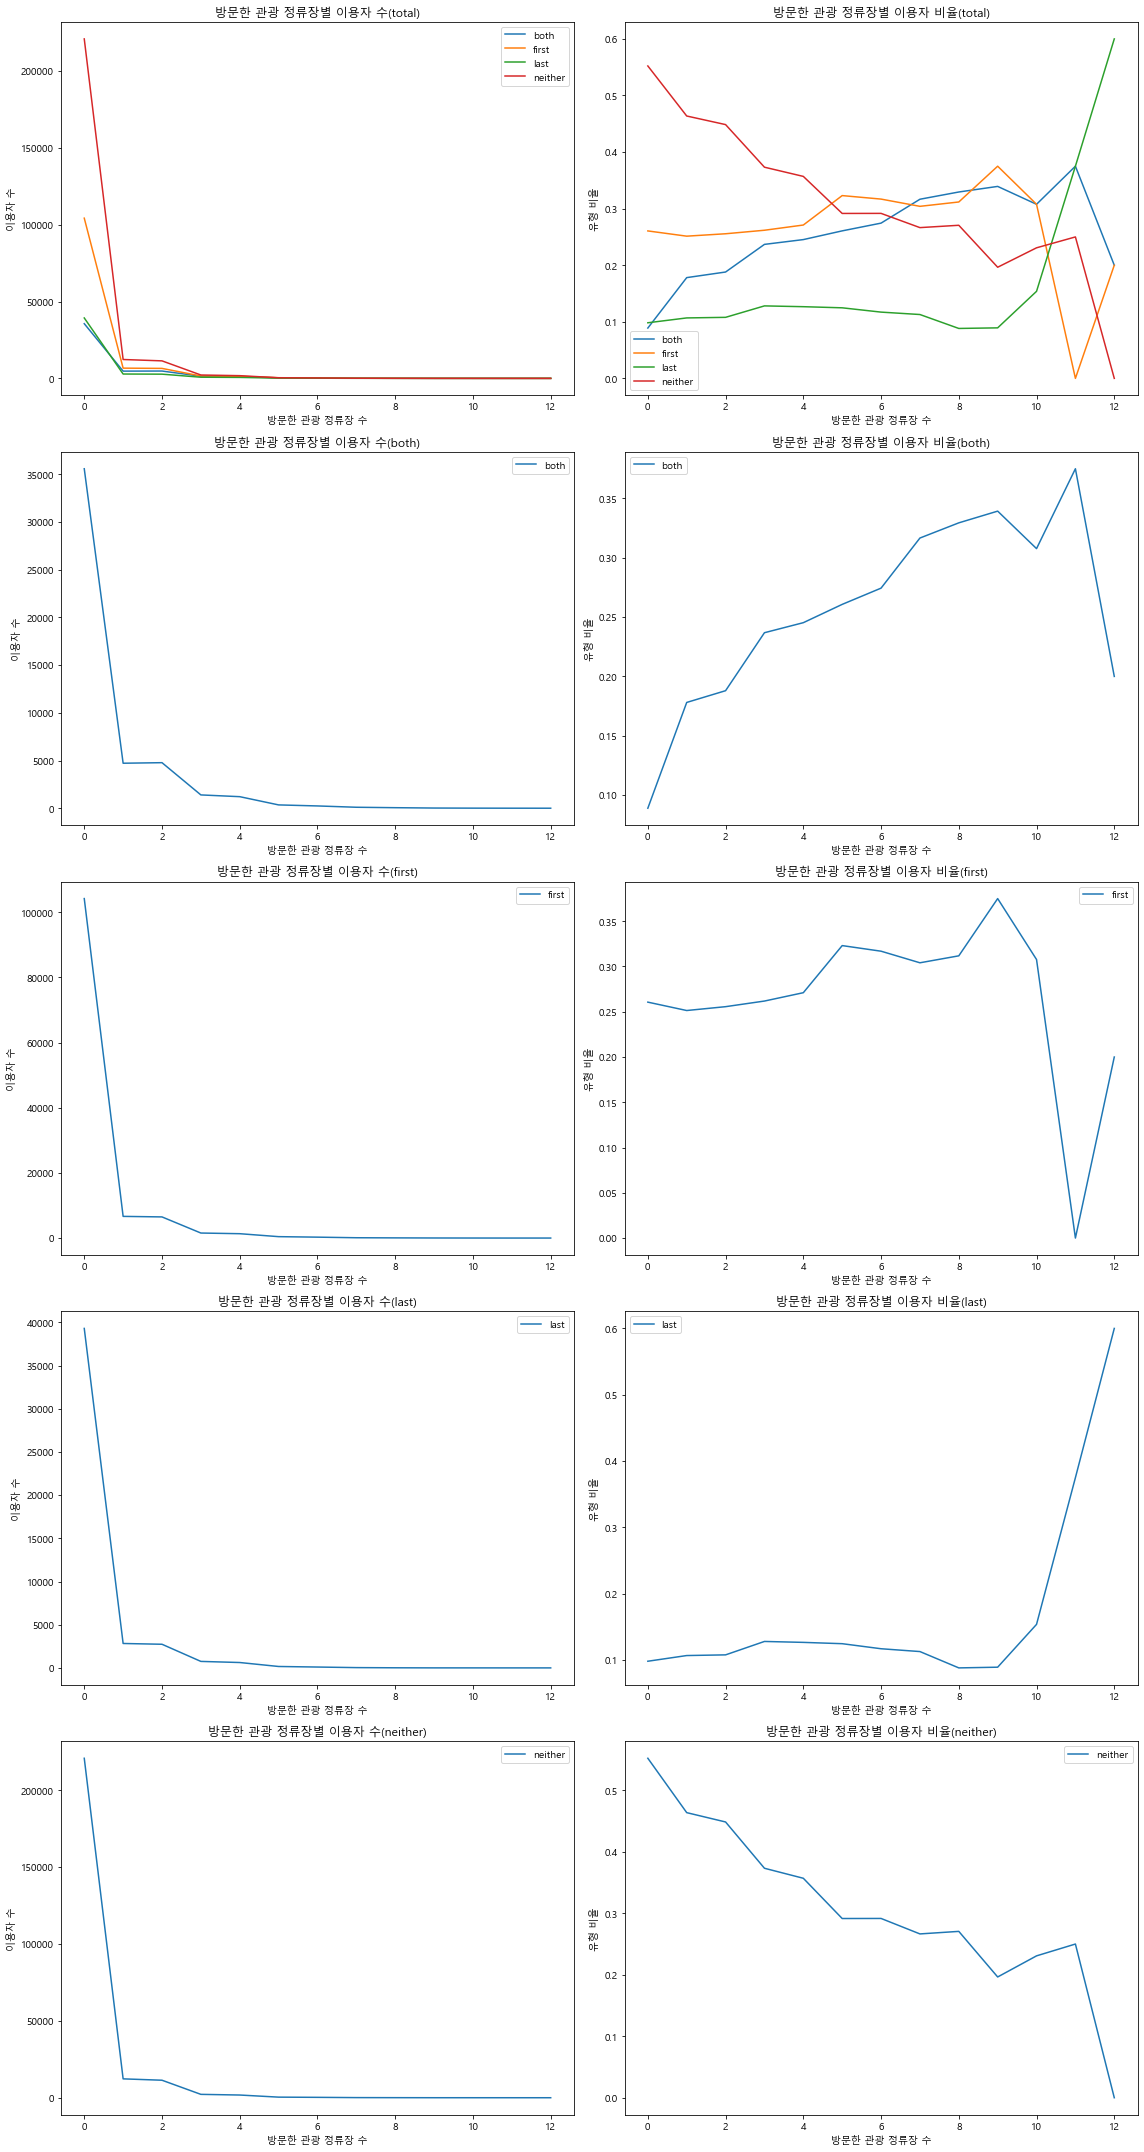

In [11]:
plt = anz.draw_tour_visit_analysis_graph(user_df[user_df["period"]<15])
plt.show()

### 3-2) 알고리즘 검증 - case검증

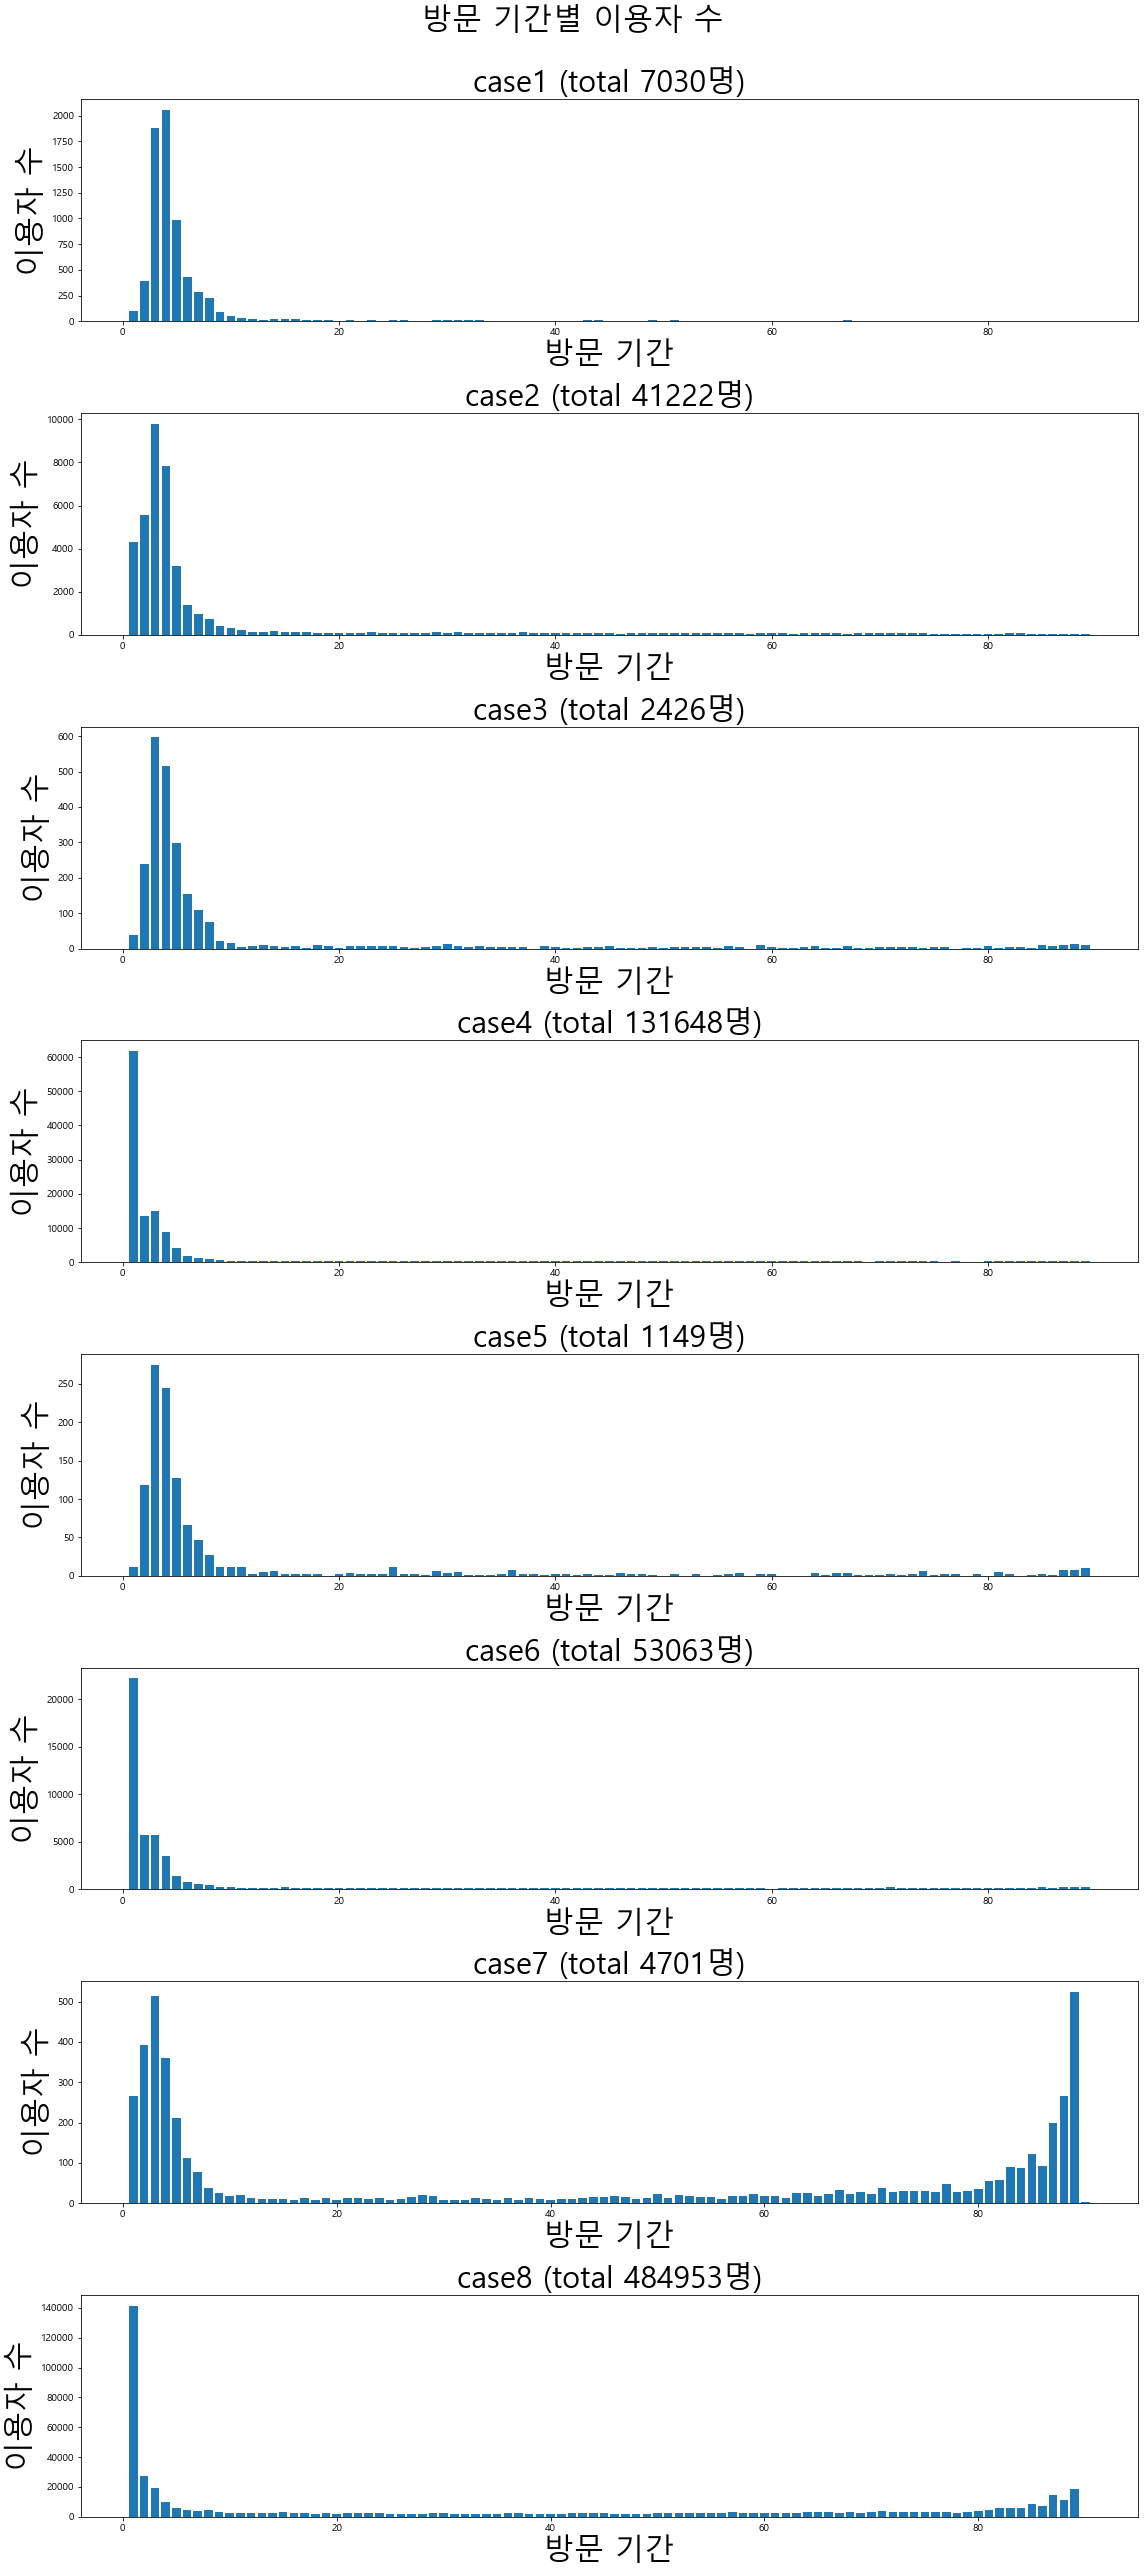

In [12]:
anz.draw_period_user_per_case(user_df)

### 3-3) 알고리즘 검증 - period검증

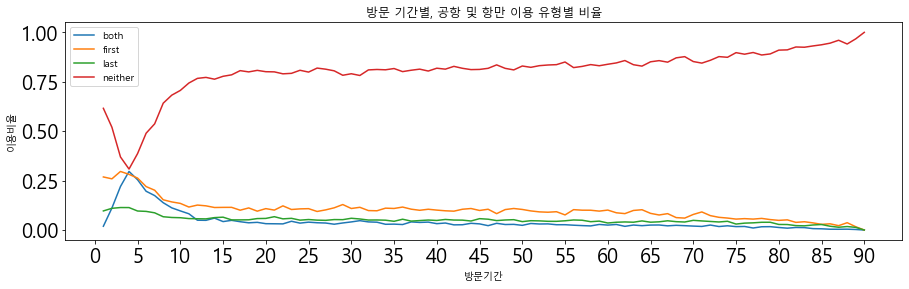

In [79]:
plt = anz.draw_period_analysis_graph(user_df)
plt.show()

### 3-4) 알고리즘 검증 - usage_ratio검증

   both 이용자수 = ( 90%미만:  22853명,  90%이상:  25399명)
  first 이용자수 = ( 90%미만:  40955명,  90%이상:  93119명)
   last 이용자수 = ( 90%미만:  18913명,  90%이상:  35299명)
neither 이용자수 = ( 90%미만: 300097명,  90%이상: 189557명)


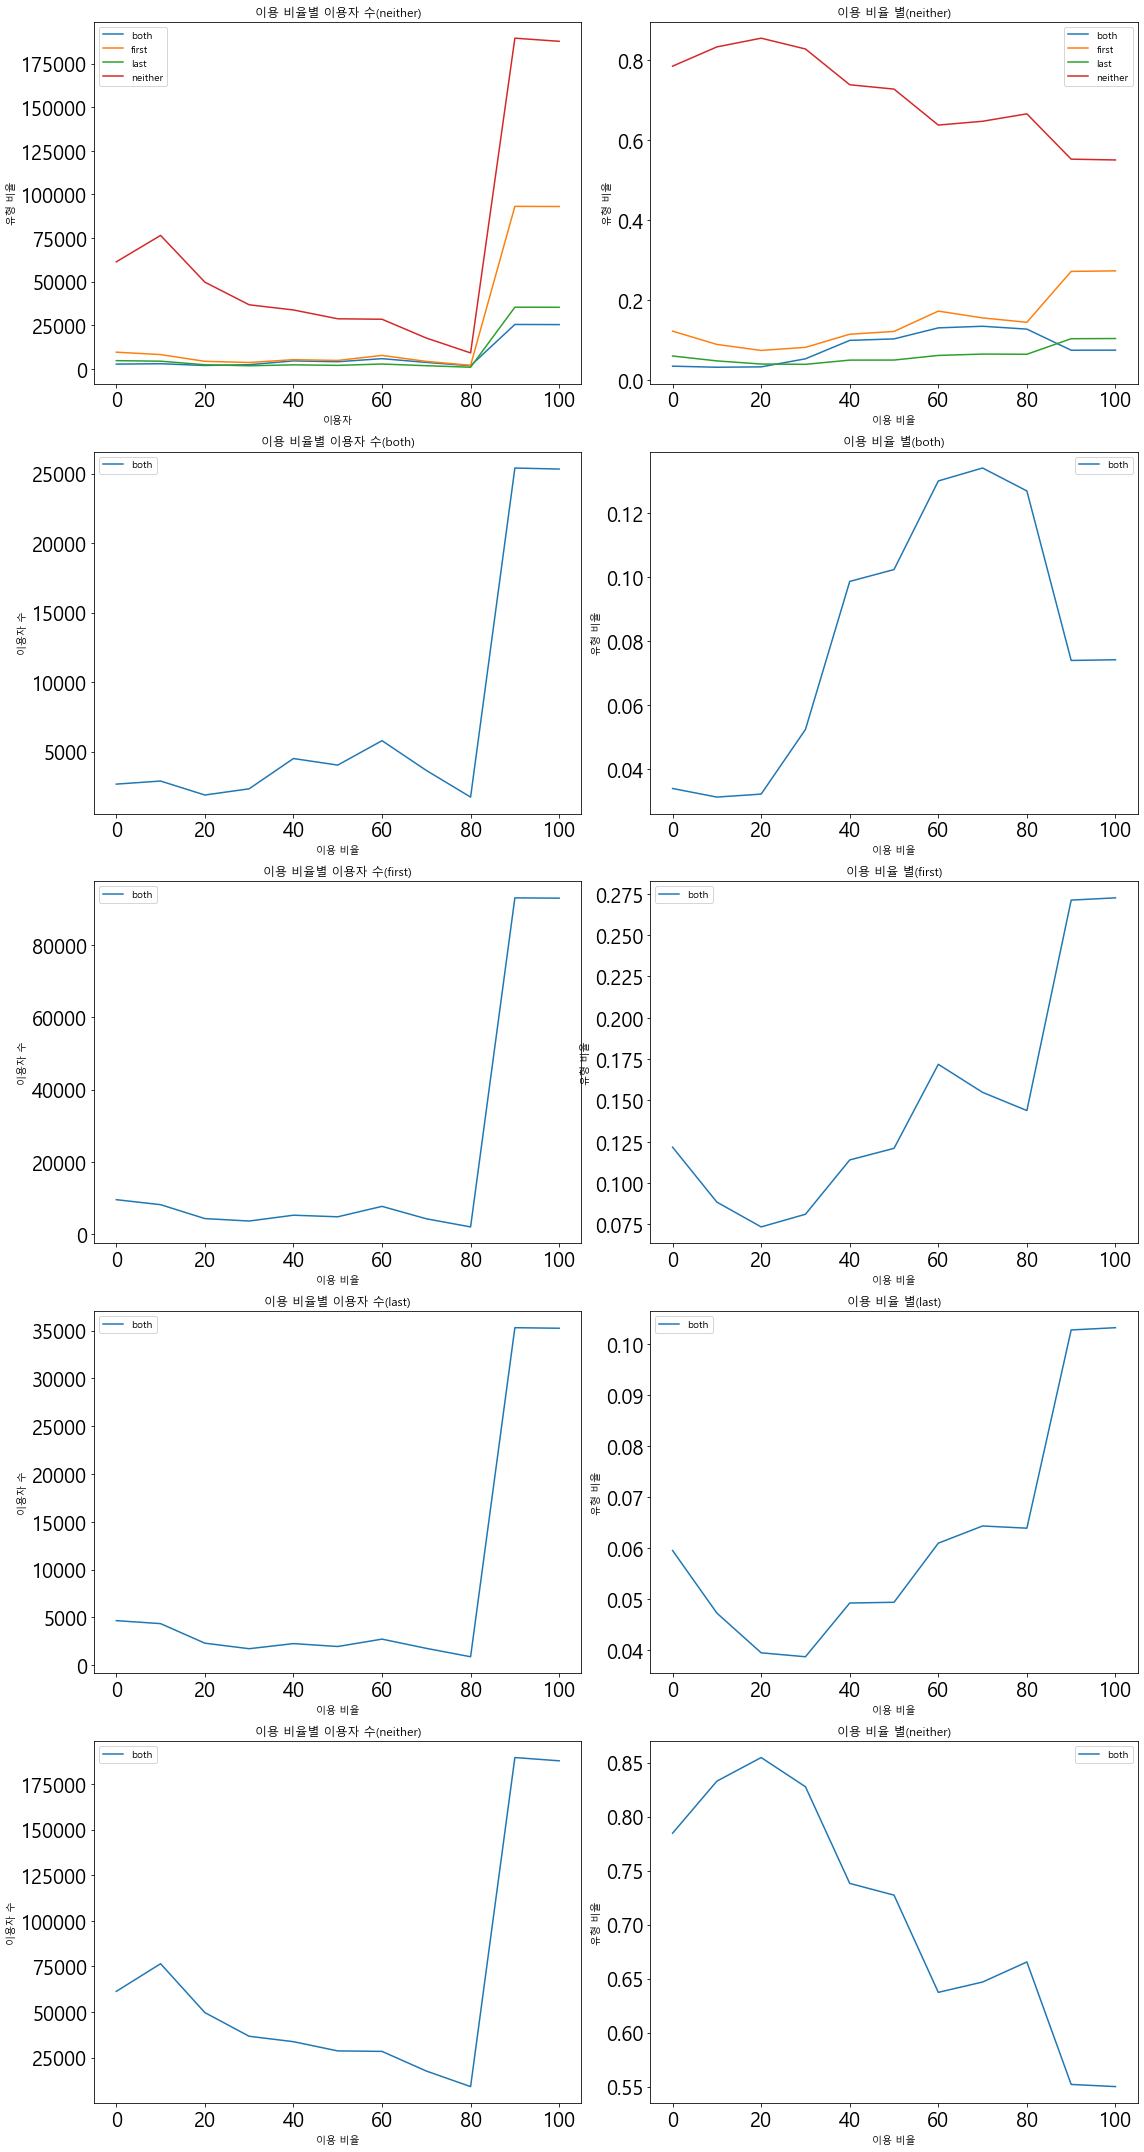

In [80]:
columns = ['both', 'first', 'last', 'neither']
boundary = 90
for column in columns:
    down = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] < boundary)])
    up = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] >= boundary)])
    print("%7s 이용자수 = (%3d%%미만: %6d명, %3d%%이상: %6d명)" % (column, boundary, down, boundary, up))
plt = anz.draw_usage_ratio_analysis_graph(user_df)
plt.show()

# 4. 결과 출력 

### 3-1) 이용자 출력

In [81]:
user_df

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,tour_visit,case,tourist
129,60126bd03aab52274cd4e09f6432ab960d49545a699ef3...,2019-06-01,2019-06-03,2,3,9,66,airport,airport,True,False,False,False,2.0,1,True
1857,67b5aff10e2b979c1da4e125e0f47f405857a12883c44b...,2019-06-01,2019-06-02,2,2,9,100,airport,airport,True,False,False,False,2.0,1,True
2251,879541bcca73469aa71daf6ce5c22df2af19a6ae9f775f...,2019-06-01,2019-08-23,26,84,47,30,airport,airport,True,False,False,False,1.0,1,False
2278,af4d652be324b8553112236b71cacd2eaa940ba896ba30...,2019-06-01,2019-06-04,4,4,21,100,airport,airport,True,False,False,False,2.0,1,True
2483,571d1c70903db31339226b0cf80a6e3fcf605c8c4a4ade...,2019-06-01,2019-06-26,13,26,36,50,harbor,airport,True,False,False,False,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726186,c1b9568d0352a747567ffc1eeb6c773f6d7a5c40b0f25e...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726187,1c0b23153f52f11215e7d1f4e45dcecfa6d669676c4a9f...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726188,8235b6d43ba2e06d89fe94fda0dfdb7b4fe678ac58eaf5...,2019-08-28,2019-08-28,1,1,1,100,other,other,False,False,False,True,0.0,8,False
726189,f6f259fe96fd2e245be452a154c7c43ac747bc0f5d5ad1...,2019-08-29,2019-08-29,1,1,1,100,other,other,False,False,False,True,0.0,8,False


### 3-2) 정류장 출력

In [16]:
station_df

,station_id,station_name,station_longitude,station_latitude,station_address,tour_geton_usage,regident_geton_usage,tour_getoff_usage,regident_getoff_usage,total_usage
3042,3271.0,제주시청(광양방면),126.53035,33.49892,제주특별자치도 제주시 이도이동 1938-1,1981.0,241714.0,1287.0,143835.0,388817.0
3041,3270.0,제주시청(아라방면),126.52977,33.49956,제주특별자치도 제주시 이도이동 1772-31,1491.0,193802.0,2160.0,160073.0,357526.0
334,357.0,한라병원,126.48508,33.48944,제주특별자치도 제주시 연동 2335-4,1275.0,137976.0,1000.0,86511.0,226762.0
335,358.0,한라병원,126.48600,33.48963,제주특별자치도 제주시 연동 251-66,1183.0,121324.0,1251.0,84701.0,208459.0
604,638.0,제주국제공항(구제주방면),126.49345,33.50661,제주특별자치도 제주시 용담이동 1462-1,10005.0,132228.0,5277.0,50603.0,198113.0
...,...,...,...,...,...,...,...,...,...,...
2505,2680.0,수산1리노인회관,126.88266,33.44670,제주특별자치도 서귀포시 성산읍 수산리 1199-1,0.0,1.0,0.0,0.0,1.0
1217,1309.0,이시돌상단지,126.33733,33.35975,제주특별자치도 제주시 한림읍 금악리 198-60,0.0,0.0,0.0,1.0,1.0
3459,4105.0,이스트힐스,126.63344,33.48146,제주특별자치도 제주시 회천동 229-3,0.0,1.0,0.0,0.0,1.0
1198,1285.0,하가삼거리,126.34830,33.45587,제주특별자치도 제주시 애월읍 하가리 1369-5,0.0,0.0,0.0,1.0,1.0


### 3-3) 방문기간 별 관광객 수 출력

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,tour_visit,case,tourist
129,60126bd03aab52274cd4e09f6432ab960d49545a699ef3...,2019-06-01,2019-06-03,2,3,9,66,airport,airport,True,False,False,False,2.0,1,True
1857,67b5aff10e2b979c1da4e125e0f47f405857a12883c44b...,2019-06-01,2019-06-02,2,2,9,100,airport,airport,True,False,False,False,2.0,1,True
2278,af4d652be324b8553112236b71cacd2eaa940ba896ba30...,2019-06-01,2019-06-04,4,4,21,100,airport,airport,True,False,False,False,2.0,1,True
2505,ea376c14800c5d78e1cbc37e81ec0d705c767d1ef8af70...,2019-06-01,2019-06-02,2,2,10,100,airport,airport,True,False,False,False,2.0,1,True
2884,ecd55c417c7db08adea0754277b090b723881c7f7a18f3...,2019-06-01,2019-06-03,3,3,13,100,airport,airport,True,False,False,False,2.0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717570,5a09bebc974f29e2fae0177524ba870466410274783f34...,2019-08-27,2019-08-28,2,2,3,100,other,other,False,False,False,True,4.0,7,True
717612,a11f7dd13ba3e1081d9714777998a2905219c72de33178...,2019-08-27,2019-08-28,2,2,4,100,other,other,False,False,False,True,4.0,7,True
717613,ae9e61fc62e0e965750d1523dd814046446a7a9db466cf...,2019-08-27,2019-08-28,2,2,4,100,other,other,False,False,False,True,4.0,7,True
717624,a504d5b199861a111a295da6f484d7615c8255f04946bb...,2019-08-27,2019-08-28,2,2,7,100,other,other,False,False,False,True,4.0,7,True


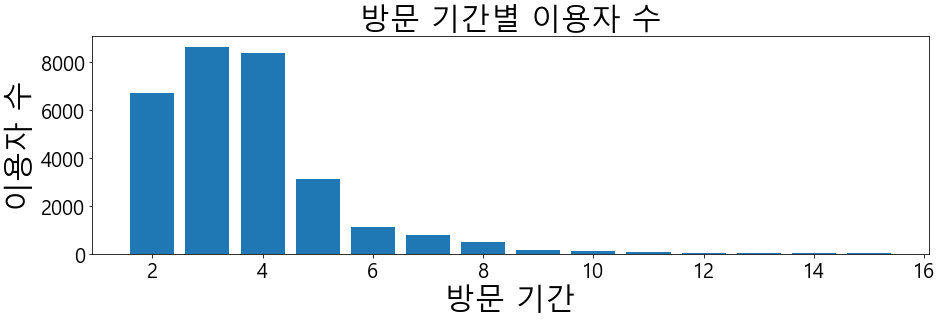

In [99]:
df = user_df[user_df["tourist"] == True]
anz.draw_period_user(plt, df)

### 3-1) both 관광객 출력

In [83]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['both'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 200)

<ipython-input-83-da876e3d4890>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['both'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1420849,20190610,2019-06-10 19:29:27,"제주국제공항(대정,화순,일주서로)",2019-06-10 19:59:03,애월환승정류장(애월리),1
1420848,20190610,2019-06-10 20:00:54,애월환승정류장(애월리),2019-06-10 20:01:40,한담동,1
1576756,20190611,2019-06-11 13:26:07,곽지해수욕장,2019-06-11 13:46:56,옹포사거리,1
1576755,20190611,2019-06-11 17:12:43,협재해수욕장,2019-06-11 17:39:23,한담동,1
1602029,20190612,2019-06-12 11:36:25,한담동,2019-06-12 12:35:08,서문시장,1
1602028,20190612,2019-06-12 14:40:17,관덕정,2019-06-12 15:00:48,이호테우해수욕장,1
1602031,20190612,2019-06-12 15:50:21,오광로입구,2019-06-12 16:23:59,곽지해수욕장,1
1602030,20190612,2019-06-12 17:20:05,곽지해수욕장,2019-06-12 18:35:13,서문시장,1
12724,20190613,2019-06-13 07:00:53,관덕정,2019-06-13 07:06:03,제주국제공항(신제주방면),1


### 3-2) first 관광객 출력

In [84]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['first'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 200)

<ipython-input-84-24ff40b1a0e1>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['first'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1523314,20190611,2019-06-11 21:29:42,제주국제공항(구제주방면),2019-06-11 21:41:58,남서광마을입구,1
1646584,20190612,2019-06-12 10:02:53,제주국제공항(구제주방면),2019-06-12 10:14:04,관덕정,1
1646585,20190612,2019-06-12 15:24:51,한담동,2019-06-12 16:48:31,산방산,1
1646583,20190612,2019-06-12 17:50:42,산방산,2019-06-12 18:36:58,진부동,1
56042,20190613,2019-06-13 10:37:18,동문로터리(동문시장),2019-06-13 10:43:20,우당도서관입구,1
56040,20190613,2019-06-13 10:54:56,6호광장,2019-06-13 11:54:45,성산항,1
56044,20190613,2019-06-13 16:24:18,성산항,2019-06-13 16:32:49,성산일출봉입구,1
56043,20190613,2019-06-13 19:13:16,성산일출봉입구,2019-06-13 19:43:19,월정리,1
56041,20190613,2019-06-13 20:47:35,월정리,2019-06-13 21:38:59,제일교동문시장입구,1


### 3-3) last 관광객 출력

In [20]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['last'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 100)

<ipython-input-20-0538c16b190b>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['last'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
1384136,20190610,2019-06-10 19:28:46,중문관광단지,2019-06-10 20:07:08,솔동산입구,4
1548287,20190611,2019-06-11 09:21:52,동문로터리,2019-06-11 09:54:27,성판악,5
1548288,20190611,2019-06-11 17:38:33,성판악,2019-06-11 18:07:53,동문로터리,1
1741453,20190612,2019-06-12 10:01:54,서귀포항,NaT,NaN,1
56116,20190613,2019-06-13 08:46:31,은남동,2019-06-13 08:58:51,제주버스터미널,5
56113,20190613,2019-06-13 09:20:01,제주버스터미널,2019-06-13 10:39:30,성산항,5
56114,20190613,2019-06-13 17:02:34,성산항,2019-06-13 18:26:19,제주버스터미널,5
56115,20190613,2019-06-13 18:32:56,제주버스터미널,2019-06-13 18:46:49,은남동,5
273518,20190614,2019-06-14 11:55:27,메종글래드제주,NaT,NaN,1
273517,20190614,2019-06-14 11:55:41,메종글래드제주,2019-06-14 12:07:02,제주국제공항(구제주방면),4


### 3-4) neither 관광객 출력

In [87]:
df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['neither'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]
anz.show_od_pattern(df, usage_df, 150)

<ipython-input-87-9fc015b0b5a4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = user_df[2<=user_df['period']][user_df["period"]<=15][user_df['neither'] == True][user_df["tour_visit"]>3][user_df['usage'] > 5]


,base_date,geton_datetime,geton_stataion_name,getoff_datetime,getoff_station_name,user_count
675738,20190605,2019-06-05 18:53:45,서문시장,2019-06-05 19:04:47,일도2동주민센터,1
675739,20190605,2019-06-05 20:41:05,제주여자상업고등학교,2019-06-05 20:55:47,화물청사입구,1
832209,20190606,2019-06-06 12:04:01,시외버스출발지(가상정류소),2019-06-06 13:50:32,성산일출봉입구,1
832213,20190606,2019-06-06 14:46:08,성산일출봉입구,2019-06-06 15:01:51,신양리입구,1
832215,20190606,2019-06-06 16:34:15,섭지코지,2019-06-06 16:39:47,고성리제주은행,1
832210,20190606,2019-06-06 16:42:21,고성리제주은행,2019-06-06 17:21:47,만장굴입구,1
832214,20190606,2019-06-06 17:45:05,만장굴입구,2019-06-06 17:48:38,행원목장,1
832211,20190606,2019-06-06 19:07:53,김녕미로공원,2019-06-06 19:11:37,만장굴입구,1
832216,20190606,2019-06-06 19:24:08,만장굴입구,2019-06-06 20:21:08,광양사거리,1
832212,20190606,2019-06-06 22:59:44,광양사거리,2019-06-06 23:04:26,제주버스터미널(종점),1


In [78]:
user_df[user_df["both"]]

,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,tour_visit,case,tourist
129,60126bd03aab52274cd4e09f6432ab960d49545a699ef3...,2019-06-01,2019-06-03,2,3,9,66,airport,airport,True,False,False,False,2.0,1,True
1857,67b5aff10e2b979c1da4e125e0f47f405857a12883c44b...,2019-06-01,2019-06-02,2,2,9,100,airport,airport,True,False,False,False,2.0,1,True
2251,879541bcca73469aa71daf6ce5c22df2af19a6ae9f775f...,2019-06-01,2019-08-23,26,84,47,30,airport,airport,True,False,False,False,1.0,1,False
2278,af4d652be324b8553112236b71cacd2eaa940ba896ba30...,2019-06-01,2019-06-04,4,4,21,100,airport,airport,True,False,False,False,2.0,1,True
2483,571d1c70903db31339226b0cf80a6e3fcf605c8c4a4ade...,2019-06-01,2019-06-26,13,26,36,50,harbor,airport,True,False,False,False,1.0,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725836,bad183985f1f44ebf5cb3a968f5bb59e93baf371c5ddc1...,2019-08-28,2019-08-28,1,1,2,100,airport,airport,True,False,False,False,0.0,2,False
725918,d124bd794f91868206d1c9d411da7f8f856b19137b950b...,2019-08-28,2019-08-28,1,1,1,100,airport,harbor,True,False,False,False,0.0,2,False
725919,9e10854ae42cda1d589f11896060170705cf5022cbb945...,2019-08-28,2019-08-28,1,1,1,100,airport,harbor,True,False,False,False,0.0,2,False
725920,ca183fc81036f23523bee7167499a7991d1bc6aa39002a...,2019-08-28,2019-08-28,1,1,1,100,harbor,harbor,True,False,False,False,0.0,2,False


<ipython-input-96-fd5e97213d96>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  x = list(user_df[user_df["both"]][user_df["tour_visit"]>3.0][user_df["period"]>=2][user_df["period"]<=15][user_df["usage_ratio"]>=0.6].groupby(by="period").count()["user_id"].index)
<ipython-input-96-fd5e97213d96>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  y = list(user_df[user_df["both"]][user_df["tour_visit"]>3.0][user_df["period"]>=2][user_df["period"]<=15][user_df["usage_ratio"]>=0.6].groupby(by="period").count()["user_id"].values)


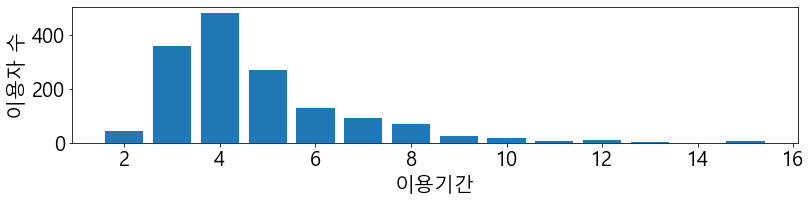

1517

In [96]:
import matplotlib.pyplot as plt
x = list(user_df[user_df["both"]][user_df["tour_visit"]>3.0][user_df["period"]>=2][user_df["period"]<=15][user_df["usage_ratio"]>=0.6].groupby(by="period").count()["user_id"].index)
y = list(user_df[user_df["both"]][user_df["tour_visit"]>3.0][user_df["period"]>=2][user_df["period"]<=15][user_df["usage_ratio"]>=0.6].groupby(by="period").count()["user_id"].values)

plt.figure(figsize=(13, 2.5))
plt.xlabel("이용기간", fontsize=20)
plt.ylabel("이용자 수", fontsize=20)

plt.bar(x, y)
plt.show()
sum(y)

   both 이용자수 = ( 90%미만:  22853명,  90%이상:  25399명)
  first 이용자수 = ( 90%미만:  40955명,  90%이상:  93119명)
   last 이용자수 = ( 90%미만:  18913명,  90%이상:  35299명)
neither 이용자수 = ( 90%미만: 300097명,  90%이상: 189557명)


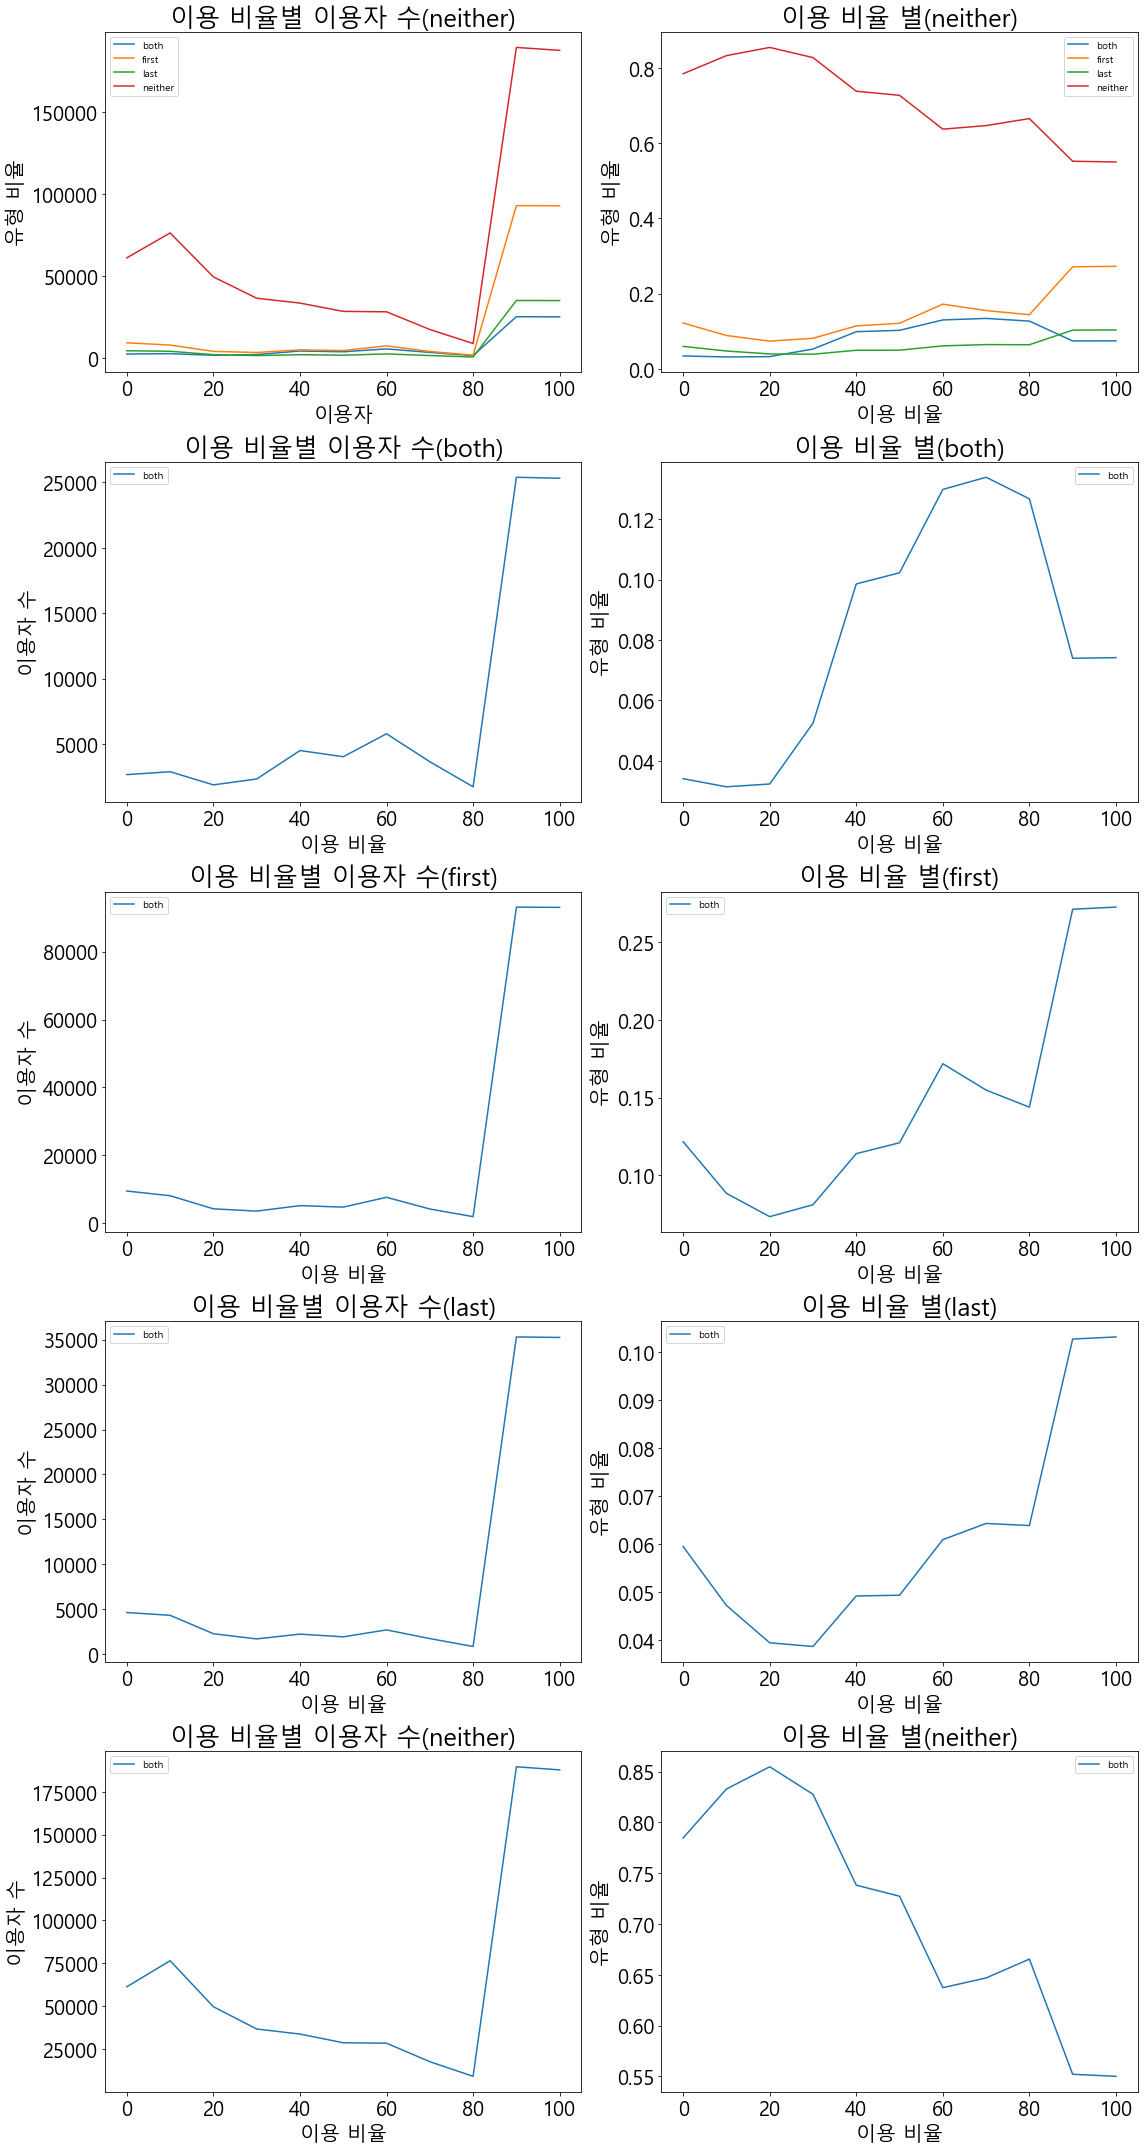

In [73]:
columns = ['both', 'first', 'last', 'neither']
boundary = 90
for column in columns:
    down = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] < boundary)])
    up = len(user_df[(user_df[column] == True) & (user_df["usage_ratio"] >= boundary)])
    print("%7s 이용자수 = (%3d%%미만: %6d명, %3d%%이상: %6d명)" % (column, boundary, down, boundary, up))
plt = draw_usage_ratio_analysis_graph(user_df)
plt.show()

In [72]:
def draw_usage_ratio_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []
    
    window_size = 10
    for i in range(0, 101, window_size):
        sample_df = user_df[(i <=user_df["usage_ratio"]) & (user_df["usage_ratio"] <= i+window_size)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df[column] == True])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    #그래프 그리기
    plt.figure(figsize=(16, 30))
    
    #그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for column in columns:
        plt.plot(list(range(0, 101, window_size)), count_values[column])
    plt.legend(columns, loc = 0)
    plt.title('이용 비율별 이용자 수({})'.format(column), fontsize=25)
    plt.xlabel("이용자", fontsize=20)
    plt.ylabel("유형 비율", fontsize=20)

    plt.subplot(5, 2, 2)
    for column in columns:
        plt.plot(list(range(0, 101, window_size)), ratio_values[column])
    plt.legend(columns, loc = 0)
    plt.title('이용 비율 별({})'.format(column), fontsize=25)
    plt.xlabel("이용 비율", fontsize=20)
    plt.ylabel("유형 비율", fontsize=20)
    
    #그래프 - 유형별 그래프
    for idx, column in enumerate(columns):
        plt.subplot(5, 2, 2*idx+3)
        plt.plot(list(range(0, 101, window_size)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('이용 비율별 이용자 수({})'.format(column), fontsize=25)
        plt.xlabel("이용 비율", fontsize=20)
        plt.ylabel("이용자 수", fontsize=20)

        plt.subplot(5, 2, 2*idx+4)
        plt.plot(list(range(0, 101, window_size)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('이용 비율 별({})'.format(column), fontsize=25)
        plt.xlabel("이용 비율", fontsize=20)
        plt.ylabel("유형 비율", fontsize=20)
        plt.rc('xtick', labelsize=20)
        plt.rc('ytick', labelsize=20)
    plt.tight_layout() 
    return plt


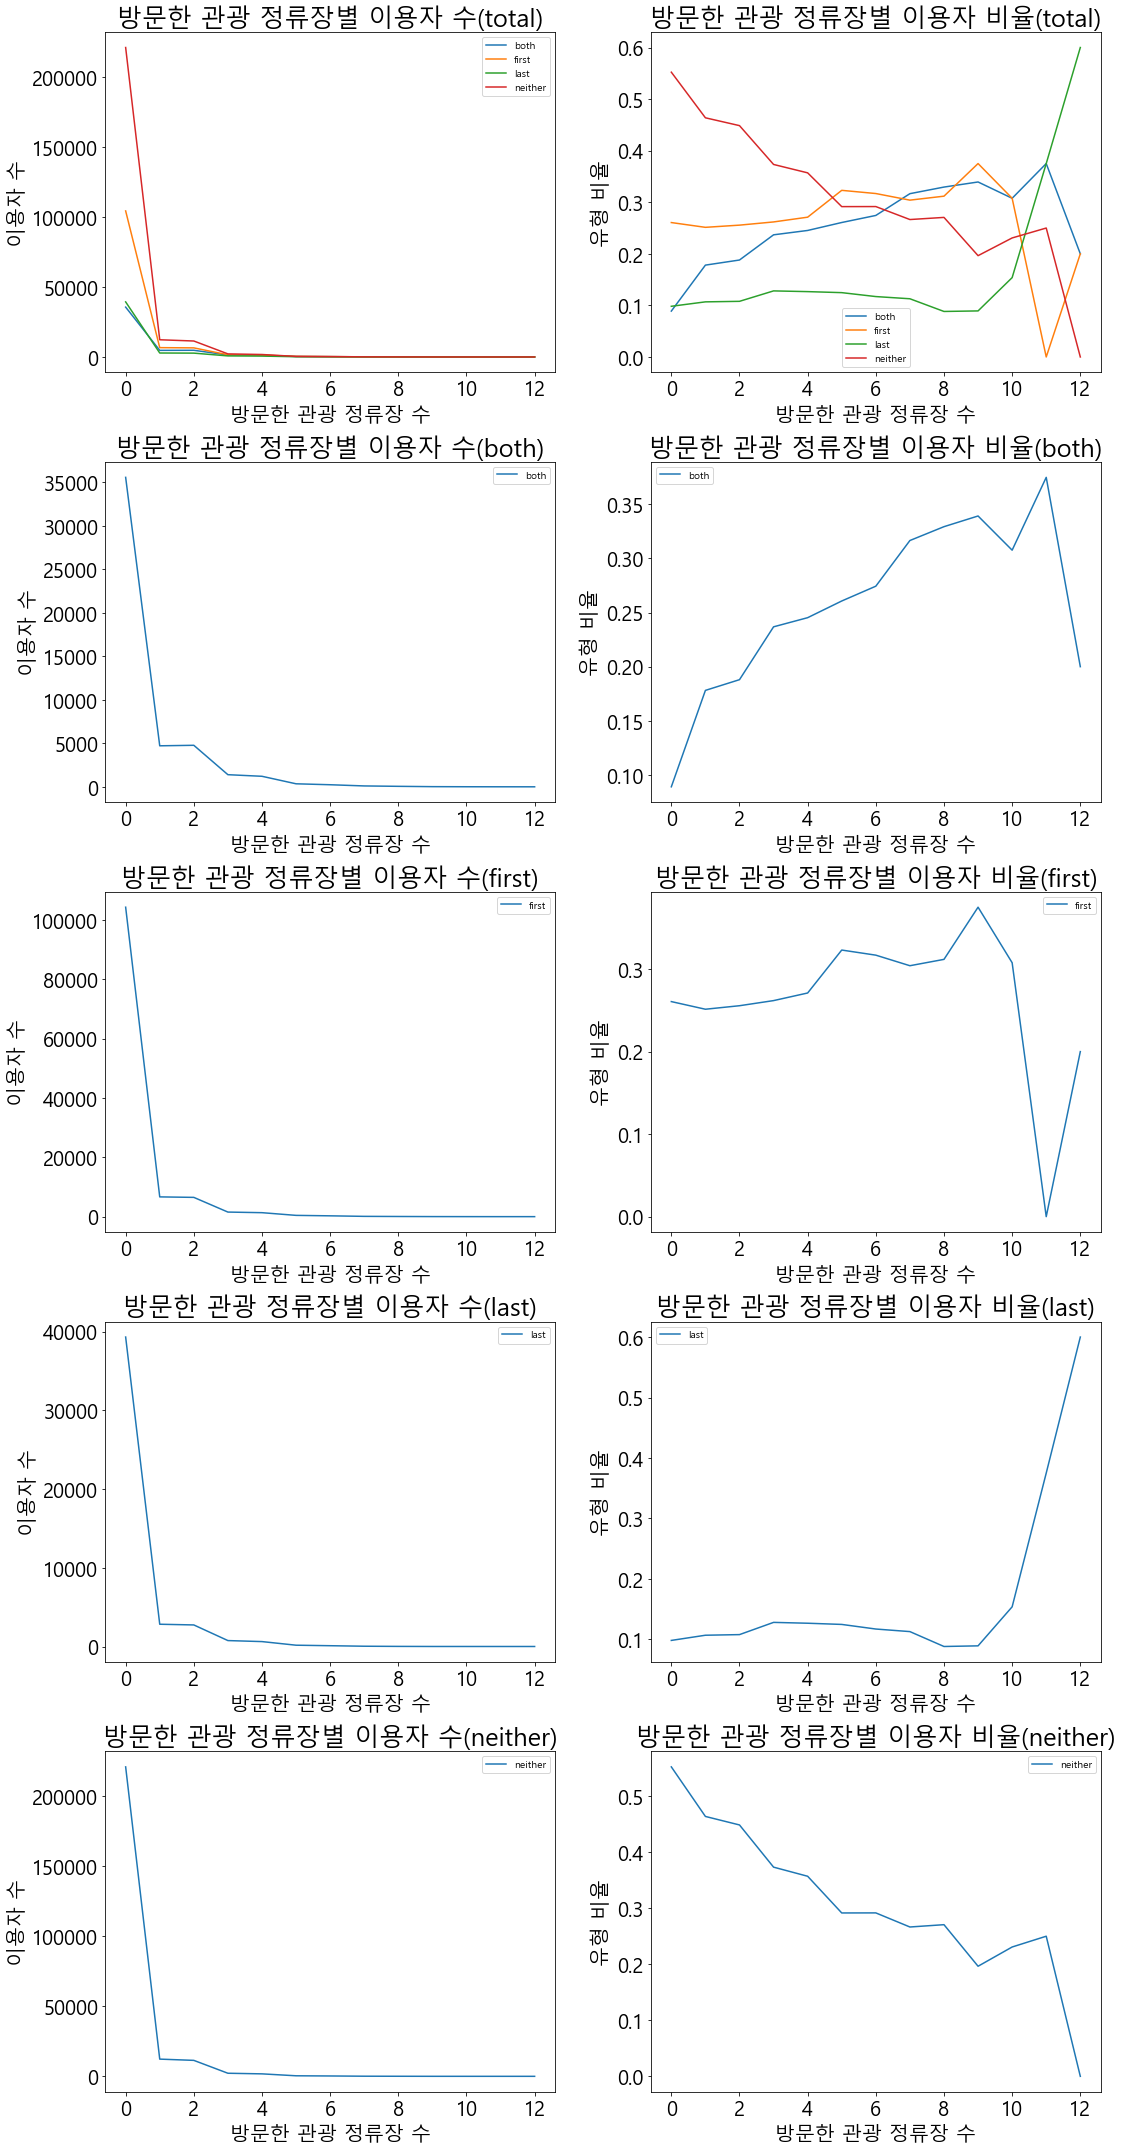

In [92]:
plt = draw_tour_visit_analysis_graph(user_df[user_df["period"]<15])
plt.show()

In [90]:
def draw_tour_visit_analysis_graph(user_df):
    # 데이터 분석
    columns = ['both', 'first', 'last', 'neither']
    ratio_values = {}
    count_values = {}
    for column in columns:
        count_values[column] = []
        ratio_values[column] = []

    max_visit = int(user_df["tour_visit"].max())
    for i in range(max_visit):
        sample_df = user_df[(i <=user_df["tour_visit"]) & (user_df["tour_visit"] <= i+1)]
        total_count = len(sample_df)
        for column in columns:
            count = len(sample_df[sample_df[column] == True])
            count_values[column].append(count)
            ratio_values[column].append(count/total_count)
    
    # 그래프 그리기
    plt.figure(figsize=(16, 30))
    
    # 그래프 - 전체 그래프
    plt.subplot(5, 2, 1)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format("total"), fontsize=25)
        plt.xlabel("방문한 관광 정류장 수", fontsize=20)
        plt.ylabel("이용자 수", fontsize=20) 
        
    # 그래프 - 유형별 그래프
    plt.subplot(5, 2, 2)
    for idx, column in enumerate(columns):
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend(columns, loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format("total"), fontsize=25)
        plt.xlabel("방문한 관광 정류장 수", fontsize=20)
        plt.ylabel("유형 비율", fontsize=20)
        
    for idx, column in enumerate(columns):
        
        plt.subplot(5, 2, 2*(idx)+3)
        plt.plot(list(range(0, max_visit, 1)), count_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 수({})'.format(column), fontsize=25)
        plt.xlabel("방문한 관광 정류장 수", fontsize=20)
        plt.ylabel("이용자 수", fontsize=20)

        plt.subplot(5, 2, 2*(idx)+4)
        plt.plot(list(range(0, max_visit, 1)), ratio_values[column])
        plt.legend([columns[idx]], loc = 0)
        plt.title('방문한 관광 정류장별 이용자 비율({})'.format(column), fontsize=25)
        plt.xlabel("방문한 관광 정류장 수", fontsize=20)
        plt.ylabel("유형 비율", fontsize=20)
    plt.tight_layout() 
    return plt

In [107]:
user_df[user_df["tourist"]][user_df["first"]]

<ipython-input-107-a60d505c5fc7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  user_df[user_df["tourist"]][user_df["first"]]


,user_id,first_date,last_date,use_days,period,usage,usage_ratio,first_station,last_station,both,first,last,neither,tour_visit,case,tourist
850,230261e50df2efeb5f8c604a2ccdc3c0d5a91f1a480ae9...,2019-06-01,2019-06-03,3,3,7,100,harbor,other,False,True,False,False,6.0,3,True
851,3c43ffbe3a4c4b815aad158f6cf437adc2c42f2cd7ec86...,2019-06-01,2019-06-03,3,3,11,100,harbor,other,False,True,False,False,9.0,3,True
7385,0ffb3603a81c17458a049dccbbb51c949fe8e4f5499de2...,2019-06-01,2019-06-04,4,4,18,100,airport,other,False,True,False,False,3.0,3,True
7389,2790a20c2df6917f7b56bf4dd243357ca7106a37dee7b0...,2019-06-01,2019-06-04,4,4,18,100,airport,other,False,True,False,False,3.0,3,True
19711,7efff66001ad324c2e7de40a4f3ed00911a592d79647c0...,2019-06-01,2019-06-04,4,4,16,100,airport,other,False,True,False,False,6.0,3,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717792,f5192d8a0f3640b48c7df2c75a60c0555b5493328f60cc...,2019-08-27,2019-08-28,2,2,6,100,airport,other,False,True,False,False,4.0,3,True
717795,b9d6a10c10971267b134ad606cfb44710392e7f1b12696...,2019-08-27,2019-08-28,2,2,6,100,airport,other,False,True,False,False,4.0,3,True
718550,2b04d56b1029107a9a63e21a740e602df5b184103fa6cb...,2019-08-27,2019-08-28,2,2,7,100,airport,other,False,True,False,False,3.0,3,True
718551,a3aaf2ec11a500622e5d1ac1e3c043c1ff6caccd6ff8f7...,2019-08-27,2019-08-28,2,2,7,100,airport,other,False,True,False,False,3.0,3,True
